# Преддипломная практика

Разработка программного обеспечения распознавания изображений с использованием методов машинного обучения на примере Частного образовательного учреждения высшего образования “Московский университет имени С.Ю. Витте

Предметная область: классификации медицинских изображений (снимков глаза) с целью выявления диабетической ретинопатии

## Загрузка датасета

In [3]:
import kagglehub

dataset_path = kagglehub.dataset_download("ruhulaminsharif/eye-disease-image-dataset")
print("Датасет загружен в папку:", dataset_path)

Датасет загружен в папку: /Users/autumnleaf/.cache/kagglehub/datasets/ruhulaminsharif/eye-disease-image-dataset/versions/1


In [4]:
# Путь к папке с изображениями (скачанный датасет)
dataset_dir = dataset_path + "/Original Dataset/Original Dataset/"

# Список категорий для классификации
categories = ["Healthy", "Diabetic Retinopathy"]

# Словарь для русской локализации при выводе графиков
mapping = {
    "Diabetic Retinopathy": "Диабетическая ретинопатия",
    "Healthy": "Здоровое состояние"
}

## Анализ исходных данных 

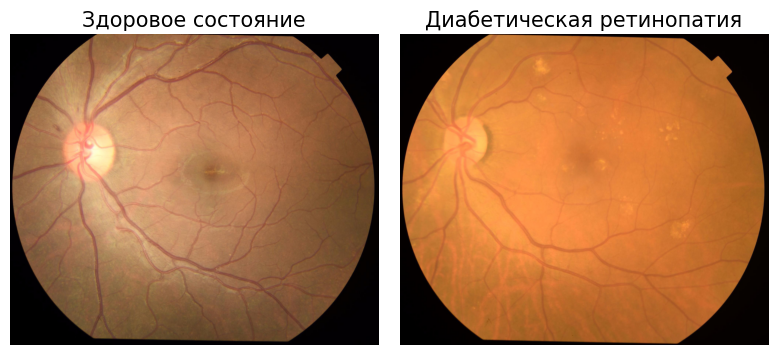

In [11]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import glob

plt.rcParams.update({"font.size": 14})

# Выводим по одному примеру изображения из каждой категории
fig, axes = plt.subplots(1, len(categories), figsize=(4 * len(categories), 4))

# Для каждой категории выводим случайное изображение
for ax, category in zip(axes, categories):
    images_folder = os.path.join(dataset_dir, category)
    pattern = os.path.join(images_folder, "*.*")
    # Список всех .jpg файлов в папке
    images_in_category = [
        file for file in glob.glob(pattern) if file.lower().endswith(".jpg")
    ]

    # Если в папке нет изображений — выводим сообщение и пропускаем
    if not images_in_category:
        display_name = mapping.get(category, category)
        ax.set_title(f"{display_name}\n(Изображения не найдены)", fontsize=20)
        ax.axis("off")
        continue # Переходим к следующей категории

    # Выбираем случайное изображение из списка
    random_image = random.choice(images_in_category)
    img = Image.open(random_image)
    ax.imshow(img, cmap="gray")
    display_name = mapping.get(category, category)
    ax.set_title(display_name, fontsize=15)
    ax.axis("off")

plt.tight_layout() # Автоматически подбираем расположение подграфиков
plt.show()

In [12]:
import os
from PIL import Image

size_info = {}  # Для каждой категории распределение по размерам изображений
category_info = {}  # Для каждой категории общее количество изображений

for category in categories:
    images_folder = os.path.join(dataset_dir, category)
    # Список файлов с нужными расширениями
    image_files = [f for f in os.listdir(
        images_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    category_sizes = {}

    for file in image_files:
        img_path = os.path.join(images_folder, file)  # Полный путь к файлу
        try:
            with Image.open(img_path) as img:
                size = img.size
                # Увеличиваем счётчик для этого размера
                category_sizes[size] = category_sizes.get(size, 0) + 1
                # Увеличиваем общий счётчик изображений в категории
                category_info[category] = category_info.get(category, 0) + 1
        except Exception as e:
            print(f"Ошибка при открытии {img_path}: {e}")

    # Сохраняем распределение размеров для текущей категории
    size_info[category] = category_sizes

# Выводим информацию о размерах изображений для каждой категории
for category, sizes in size_info.items():
    print(f"\nКатегория '{category}':")
    if sizes:
        for size, count in sizes.items():
            print(f"  Размер {size}: {count} изображений")
    else:
        print("  Изображения не найдены.")

# Выводим общее количество изображений во всех категориях
print(f"Всего изображений: {sum(category_info.values())}")


Категория 'Healthy':
  Размер (2004, 1690): 1024 изображений

Категория 'Diabetic Retinopathy':
  Размер (2004, 1690): 1509 изображений
Всего изображений: 2533


- Количество изображений и категорий совпадает с описанием датасета на его странице в Kaggle
- Все изображения одного размера 2004: на 1690 пикселей

In [13]:
import plotly.express as px
import pandas as pd

# Формируем словарь с данными для графика
# category: список названий категорий
# count: количество изображений в каждой категории
data = {
    "category": [mapping.get(k, k) for k in category_info.keys()],
    "count": list(category_info.values()),
}
df = pd.DataFrame(data)
# Общее количество изображений во всех категориях
total = df["count"].sum()
# Добавляем столбец с процентом от общего числа
df["perc"] = df["count"] / total * 100

# Строим столбчатую диаграмму
fig = px.bar(
    df,
    x="category",
    y="count",
    text=df.apply(lambda row: f"{row['count']} ({row['perc']:.1f}%)", axis=1), # Подписи на столбцах: число и процент
    title="Распределение изображений по диагностическим группам",
    labels={"category": "Группа", "count": "Количество"}, # Подписи осей
    height=600,
)

# Настройка размер шрифта, отображение текста
fig.update_layout(uniformtext_minsize=16,
                  uniformtext_mode="hide", font=dict(size=18))
fig.show()

Как видно из графика, большого дисбаланса между группами нет

## Подготовка данных

In [14]:
import os
from torchvision import transforms
from PIL import Image

# Последовательность преобразований для изображений
# Изменяем размер до 224x224 (стандарт для многих моделей)
# Преобразуем изображение в тензор PyTorch
transform = transforms.Compose(
    [transforms.Resize((224, 224)), 
     transforms.ToTensor()])

# Получаем путь к примеру изображения из первой категории
example_path = os.path.join(
    dataset_dir,
    categories[0],
    os.listdir(os.path.join(dataset_dir, categories[0]))[0],
)
# Открываем изображение, применяем преобразования и выводим форму тензора
with Image.open(example_path) as img:
    tensor_img = transform(img) # Применяем transform
    print("Форма тензора:", tensor_img.shape)

Форма тензора: torch.Size([3, 224, 224])


In [ ]:
import os
from PIL import Image

def load_dataset(root_dir, transform, categories):
    images_list = []  # Список для хранения преобразованных изображений (тензоров)
    labels_list = [] # Список для хранения меток классов

    # Проходим по всем категориям
    for label, category in enumerate(categories):
        images_folder = os.path.join(root_dir, category)
        # Гарантируем стабильный порядок файлов
        image_files = sorted([
            f for f in os.listdir(images_folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ])
        # Проходим по каждому файлу изображения
        for f in image_files:
            try:
                img_path = os.path.join(images_folder, f)  # Полный путь к изображению
                img = Image.open(img_path).convert("RGB")  # Открываем и приводим к RGB
                img_tensor = transform(img)  # Применяем преобразования
                images_list.append(img_tensor)
                labels_list.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    # Возвращаем списки изображений, меток и список категорий
    return images_list, labels_list, categories

In [10]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import StratifiedShuffleSplit

def split_and_save_indices(images, labels, test_size=0.3, random_state=123, save_path="data/dataset_splits.npz"):
    # Преобразуем данные в тензоры
    labels_tensor = torch.tensor(labels, dtype=torch.long) if isinstance(labels, list) else labels
    all_labels = labels_tensor.numpy()

    # Разбиваем на обучающую и временную выборки
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, temp_idx = next(sss1.split(np.zeros(len(all_labels)), all_labels))

    # Разбиваем временную выборку на валидационную и тестовую
    temp_labels = labels_tensor[temp_idx].numpy()
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=random_state)
    val_idx_temp, test_idx_temp = next(sss2.split(np.zeros(len(temp_labels)), temp_labels))

    val_idx = [temp_idx[i] for i in val_idx_temp]
    test_idx = [temp_idx[i] for i in test_idx_temp]

    np.savez(save_path, train=train_idx, val=val_idx, test=test_idx)
    print(f"Индексы сохранены в '{save_path}'")

    return train_idx, val_idx, test_idx

def load_indices(path="data/dataset_splits.npz"):
    data = np.load(path)
    return data["train"], data["val"], data["test"]

def create_loaders_from_indices(images, labels, train_idx, val_idx, test_idx, batch_size=32):
    images_tensor = torch.stack(images) if isinstance(images, list) else images
    labels_tensor = torch.tensor(labels, dtype=torch.long) if isinstance(labels, list) else labels
    dataset = TensorDataset(images_tensor, labels_tensor)

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)
    test_dataset = Subset(dataset, test_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("Размер обучающего набора:", len(train_dataset))
    print("Размер валидационного набора:", len(val_dataset))
    print("Размер тестового набора:", len(test_dataset))

    return train_loader, val_loader, test_loader

def prepare_data(images, labels, test_size=0.3, batch_size=32, index_file="data/dataset_splits.npz", random_state=123):
    if os.path.exists(index_file):
        print(f"Загружаем индексы из '{index_file}'")
        train_idx, val_idx, test_idx = load_indices(index_file)
    else:
        print("Разбиваем датасет и сохраняем индексы...")
        train_idx, val_idx, test_idx = split_and_save_indices(images, labels, test_size, random_state, index_file)

    return create_loaders_from_indices(images, labels, train_idx, val_idx, test_idx, batch_size)

In [11]:
images, labels, class_names = load_dataset(dataset_dir, transform, categories)
print(f"Загружено {len(images)} изображений из {len(class_names)} категорий.")

test_size = 0.3
batch_size = 32
train_loader, val_loader, test_loader = prepare_data(images, labels, test_size, batch_size)

Загружено 2533 изображений из 2 категорий.
Загружаем индексы из 'data/dataset_splits.npz'
Размер обучающего набора: 1773
Размер валидационного набора: 380
Размер тестового набора: 380


## Создание и обучение модели

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.optim.lr_scheduler import StepLR

def train_binary_model(
    model,
    train_loader,
    val_loader,
    num_epochs=50,
    lr=0.001,
    weight_decay=1e-4,
    step_size=10,
    gamma=0.5,
    early_stopping_patience=10
):
    # Определяем устройство для вычислений (используем MPS, если доступно, иначе CUDA или CPU)
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    print("Используем устройство:", device)
    model.to(device)

    # Определяем функцию потерь (BCEWithLogitsLoss для бинарной классификации)
    criterion = nn.BCEWithLogitsLoss()
    # Оптимизатор Adam с регуляризацией (weight_decay)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # Планировщик уменьшения learning rate (каждые step_size эпох умножает lr на gamma)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    # Списки для хранения истории обучения
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float("inf")  # Лучшее значение потерь на валидации
    patience_counter = 0  # Счётчик эпох без улучшения
    best_model_state = None  # Снимок лучших весов модели

    # Засекаем время обучения
    start_time = time.time()  

    for epoch in range(num_epochs):
        # Переводим модель в режим обучения
        model.train()
        running_loss = 0.0  # Суммарные потери за эпоху
        correct = 0  # Количество правильных предсказаний
        total = 0  # Всего примеров

        # Обучение на батчах
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            # Приводим targets к float и добавляем размерность для BCEWithLogitsLoss
            targets = targets.to(device).float().unsqueeze(1)
            optimizer.zero_grad()  # Обнуляем градиенты
            outputs = model(inputs)   # Прямой проход
            loss = criterion(outputs, targets)  # Вычисляем потери
            loss.backward()  # Обратное распространение ошибки
            optimizer.step()  # Обновляем веса

            running_loss += loss.item() * inputs.size(0)  # Суммируем потери по батчам
            preds = (torch.sigmoid(outputs) >= 0.5).float()  # Получаем бинарные предсказания
            correct += (preds == targets).sum().item()  # Считаем количество верных ответов
            total += targets.size(0)  # Считаем количество примеров

        train_loss = running_loss / total  # Средняя потеря на обучении
        train_acc = correct / total  # Точность на обучении
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Валидация
        model.eval() # Переводим модель в режим оценки
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():  # Отключаем вычисление градиентов (ускоряет инференс)
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device).float().unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                preds = (torch.sigmoid(outputs) >= 0.5).float()
                correct += (preds == targets).sum().item()
                total += targets.size(0)

        val_loss = val_loss / total   # Средняя потеря на валидации
        val_acc = correct / total  # Точность на валидации
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Выводим метрики текущей эпохи
        print(
            f"Эпоха {epoch+1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        # Делаем шаг планировщика learning rate 
        scheduler.step()

        # Сохраняем лучшую модель по валидационной потере
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
            print("Новая лучшая модель сохранена.")
        else:
            patience_counter += 1
            # Если нет улучшения несколько эпох подряд, то останавливаем обучение (early stopping)
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping (без улучшений {early_stopping_patience} эпох)")
                break

    end_time = time.time()
    print("Время обучения: {:.2f} сек".format(end_time - start_time))

    # После окончания обучения загружаем веса лучшей модели
    model.load_state_dict(best_model_state)

    # Возвращаем модель и историю обучения для дальнейшего анализа
    return {
        "model": model,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
    }

In [13]:
import torch
import pandas as pd

def save_model_and_metrics(model, train_losses, val_losses, train_accuracies, val_accuracies,
                           model_path, csv_path):
    torch.save(model.state_dict(), model_path)
    print(f"Модель сохранена в файл '{model_path}'")

    metrics_df = pd.DataFrame({
        "epoch": list(range(1, len(train_losses) + 1)),
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_accuracy": train_accuracies,
        "val_accuracy": val_accuracies,
    })

    metrics_df.to_csv(csv_path, index=False)
    print(f"Метрики обучения сохранены в файл '{csv_path}'")

In [14]:
import matplotlib.pyplot as plt

def plot_training_history(
    train_losses: list,
    val_losses: list,
    train_accuracies: list,
    val_accuracies: list,
    num_epochs: int | None = None,
    figsize: tuple = (12, 5),
):
    if num_epochs is None:
        num_epochs = len(train_losses)

    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Потеря на обучении")
    plt.plot(epochs, val_losses, label="Потеря на валидации")
    plt.xlabel("Эпоха")
    plt.ylabel("Потеря")
    plt.title("График потери")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Точность на обучении")
    plt.plot(epochs, val_accuracies, label="Точность на валидации")
    plt.xlabel("Эпоха")
    plt.ylabel("Точность")
    plt.title("График точности")
    plt.legend()

    plt.tight_layout()
    plt.show()

### Запуск обучения

In [107]:
from utils.model import BinaryCNN

model = BinaryCNN()
print(model)

num_epochs = 50
results = train_binary_model(model, train_loader, val_loader, num_epochs)

BinaryCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
Используем устройство: mps
Эпоха 1/50 | Train Loss: 0.4982, Train Acc: 0.7688 | Val Loss: 0.5344, Val Acc: 0.7237
Новая лучшая модель сохранена.
Эпоха 2/50 | Train Loss: 0.4511, Train Acc: 0.7812 | Val Loss: 0.5611, Val Acc: 0.6421
Эпоха 3/50 | T

Модель сохранена в файл 'data/initial_model.pth'
Метрики обучения сохранены в файл 'data/initial_model.csv'


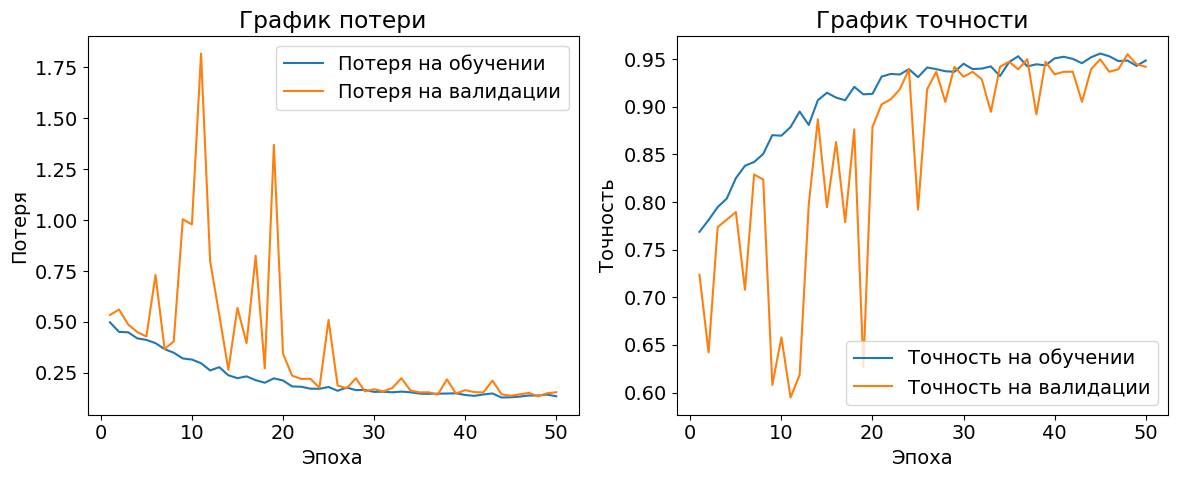

In [ ]:
train_losses = results["train_losses"]
val_losses = results["val_losses"]
train_accuracies = results["train_accuracies"]
val_accuracies = results["val_accuracies"]

save_model_and_metrics(
    model,
    train_losses,
    val_losses,
    train_accuracies,
    val_accuracies,
    model_path="data/model1.pth",
    csv_path="data/model1.csv",
)

plot_training_history(train_losses, val_losses,
                      train_accuracies, val_accuracies)

На графиках видно, что в процессе обучения модель демонстрировала устойчивый рост точности на обучающей выборке, достигая значения выше 95%. Однако точность на валидации колебалась: после начального роста она периодически падала.


## Тестирование модели

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_binary_model(
    model,
    test_loader,
    class_names=["Healthy", "Diabetic Retinopathy"],
    threshold=0.5,
    plot_title="Матрица ошибок на тестовой выборке"
):
    # Определяем устройство для вычислений (GPU/CPU/MPS)
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    print("Используем устройство:", device)

    model.to(device)
    # Переводим модель в режим оценки
    model.eval()

    all_preds = []  # Список для предсказаний модели
    all_labels = []  # Список для истинных меток

    with torch.no_grad():  # Отключаем вычисление градиентов, что ускоряет инференс
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device).float().unsqueeze(1)  # Приводим к нужной форме
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)  # Получаем вероятности
            preds = (probs >= threshold).int()  # Бинаризация по порогу

            all_preds.extend(preds.cpu().numpy())  # Сохраняем предсказания
            all_labels.extend(targets.cpu().numpy())  # Сохраняем истинные метки

    # Преобразуем к int для корректной работы sklearn
    all_preds = [int(x[0]) for x in all_preds]
    all_labels = [int(x[0]) for x in all_labels]

    # Выводим отчёт по метрикам классификации
    print("Отчет классификации:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Матрица ошибок
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots()
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, ax=ax)
    # Добавляем русские подписи осей
    ax.set_xlabel('Предсказанная метка')
    ax.set_ylabel('Истинная метка')
    plt.title(plot_title)
    plt.show()

### Запуск оценки с использованием сохраненной модели

Используем устройство: mps
Отчет классификации:
                            precision    recall  f1-score   support

       Здоровое
 состояние       0.97      0.89      0.93       150
Диабетическая
 ретинопатия       0.93      0.98      0.96       230

                  accuracy                           0.94       380
                 macro avg       0.95      0.93      0.94       380
              weighted avg       0.95      0.94      0.94       380



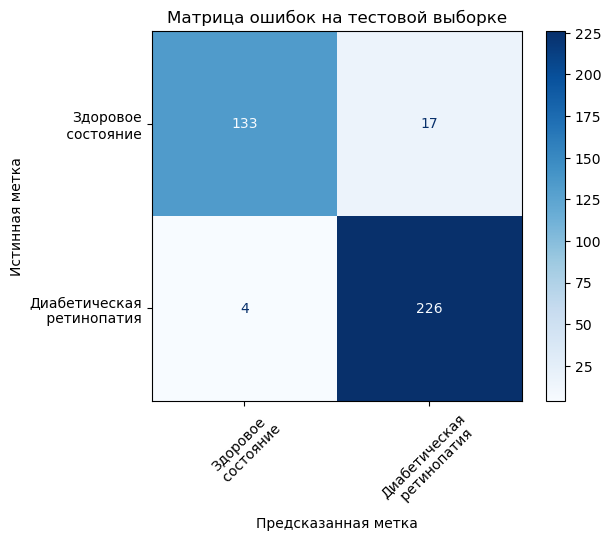

In [19]:
from utils.model import BinaryCNN

model = BinaryCNN()
model.load_state_dict(torch.load("data/model1.pth"))
model.eval()

evaluate_binary_model(
    model,
    test_loader,
    class_names=["Здоровое\n состояние", "Диабетическая\n ретинопатия"],
    threshold=0.5 
)

## Визуализация зон внимания модели

Предсказание: Diabetic Retinopathy
Healthy:              0.0000 (0.00%)
Diabetic Retinopathy: 1.0000 (100.00%)
Истинная метка: Diabetic Retinopathy


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



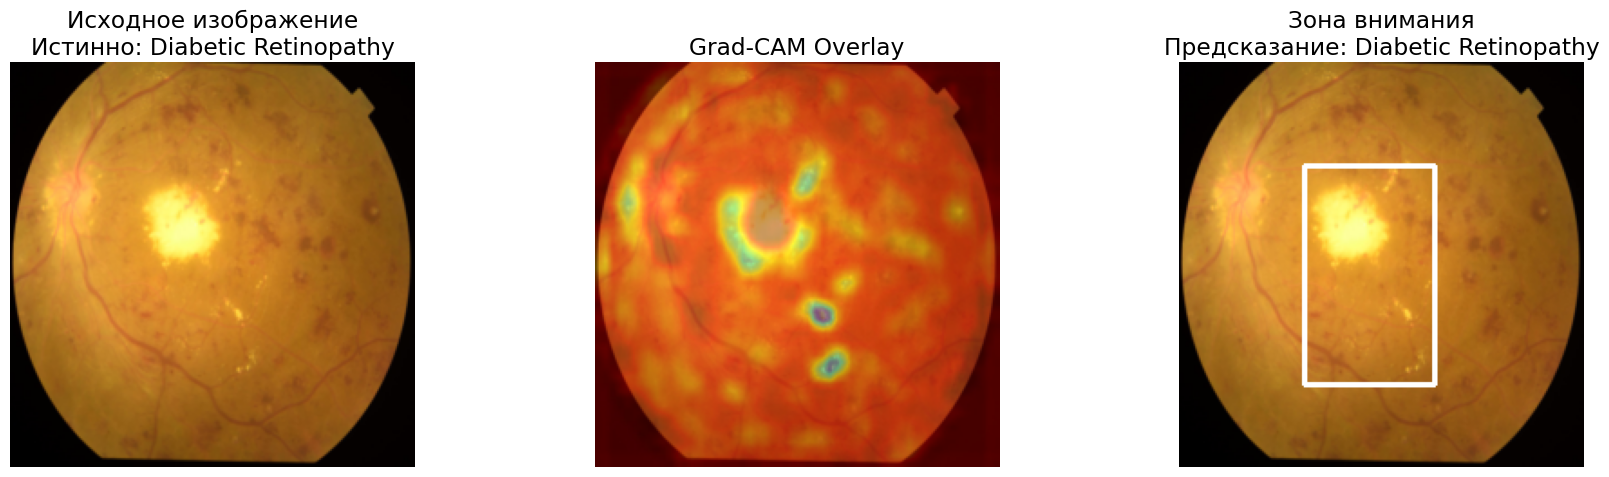

In [ ]:
import random
from utils.visualisation import generate_gradcam, draw_merged_boxes
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2

# Определяем устройство для вычислений
device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available() else "cpu")

# Последовательность преобразований для тестового изображения
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменяем размер до 224x224
    transforms.ToTensor()           # Преобразуем в тензор PyTorch
])

# Выбираем случайный пример из тестовой выборки
idx = random.randint(0, len(test_loader.dataset) - 1)
original_image, label = test_loader.dataset[idx]

# Конвертируем изображение и переводим в numpy-массив для визуализации
original_pil = transforms.ToPILImage()(original_image).convert("RGB")
original_np = np.array(original_pil)

# Применяем те же преобразования, что и при обучении, и переносим на устройство
input_tensor = transform(original_pil).to(device)
input_tensor_unsq = input_tensor.unsqueeze(0)  # Добавляем размерность батча

# Получаем предсказание модели и вероятность класса
model.eval()
model.to(device)
with torch.no_grad():
    output = model(input_tensor_unsq)
    prob = torch.sigmoid(output).item()
    prediction = int(prob >= 0.5)

# Генерируем тепловую карту внимания (Grad-CAM) для предсказанного класса
overlay_small, cam_resized_small = generate_gradcam(
    model, input_tensor, target_class=prediction)

# Масштабируем тепловую карту до исходного размера изображения
overlay = cv2.resize(
    overlay_small, (original_np.shape[1], original_np.shape[0]))
cam_resized = cv2.resize(
    cam_resized_small, (original_np.shape[1], original_np.shape[0]))

# Выделяем зоны внимания на изображении по тепловой карте
boxed_overlay = draw_merged_boxes(
    original_np, cam_resized,
    threshold=0.5,  # Порог для выделения областей
    dilation_iter=3, # Количество итераций дилатации
    min_area=200,  # Минимальная площадь области
    merge_distance=50  # Максимальное расстояние для объединения прямоугольников
)

# Формируем подписи классов и вероятности
class_names = ["Healthy", "Diabetic Retinopathy"]
true_class = class_names[label]  # Истинный класс
pred_class = class_names[prediction]  # Предсказанный класс
prob_healthy = 1 - prob  # Вероятность "Healthy"
prob_dr = prob  # Вероятность "Diabetic Retinopathy"

# Выводим информацию о предсказании
print(f"Предсказание: {pred_class}")
print(f"Healthy:              {prob_healthy:.4f} ({prob_healthy*100:.2f}%)")
print(f"Diabetic Retinopathy: {prob_dr:.4f} ({prob_dr*100:.2f}%)")
print(f"Истинная метка: {true_class}")

# Визуализируем исходное изображение, Grad-CAM и зоны внимания
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.title(f"Исходное изображение\nИстинно: {true_class}")
plt.imshow(original_np)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Зона внимания\nПредсказание: {pred_class}")
plt.imshow(boxed_overlay)
plt.axis("off")

plt.tight_layout()
plt.show()

## Улучшение модели

In [ ]:
from utils.model import BinaryImprovedCNN

model = BinaryImprovedCNN()
print(model)

num_epochs = 50
results = train_binary_model(model, train_loader, val_loader, num_epochs)

Binary1CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (activation): LeakyReLU(negative_slope=0.1)
)
Используем устройство: mps
Эпо

Модель сохранена в файл 'data/model2.pth'
Метрики обучения сохранены в файл 'data/model2.csv'


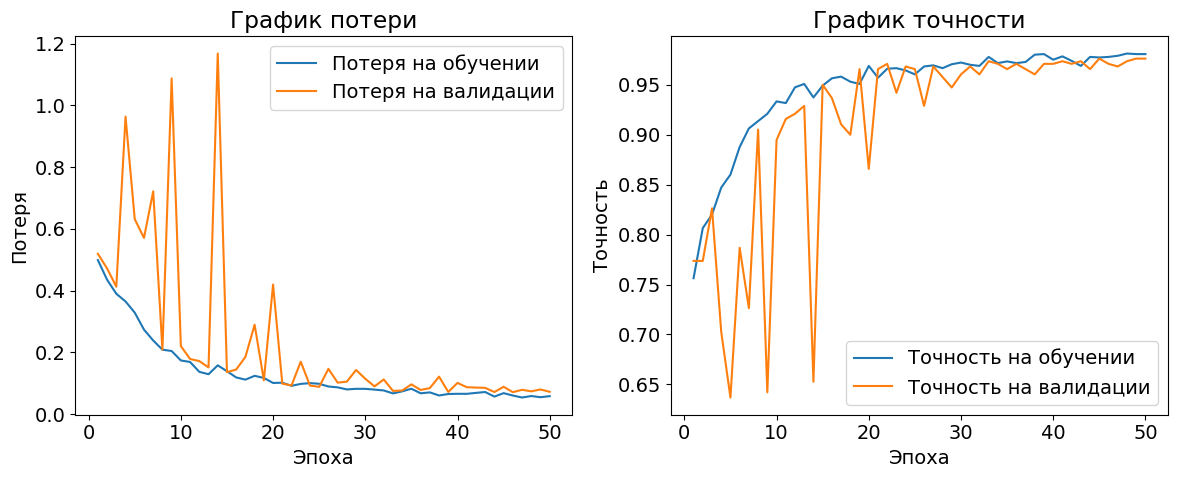

In [25]:
train_losses = results["train_losses"]
val_losses = results["val_losses"]
train_accuracies = results["train_accuracies"]
val_accuracies = results["val_accuracies"]

save_model_and_metrics(
    model,
    train_losses,
    val_losses,
    train_accuracies,
    val_accuracies,
    model_path="data/model2.pth",
    csv_path="data/model2.csv",
)

plot_training_history(train_losses, val_losses,
                      train_accuracies, val_accuracies)

Используем устройство: mps
Отчет классификации:
                            precision    recall  f1-score   support

       Здоровое
 состояние       0.94      0.99      0.97       150
Диабетическая
 ретинопатия       1.00      0.96      0.98       230

                  accuracy                           0.97       380
                 macro avg       0.97      0.98      0.97       380
              weighted avg       0.97      0.97      0.97       380



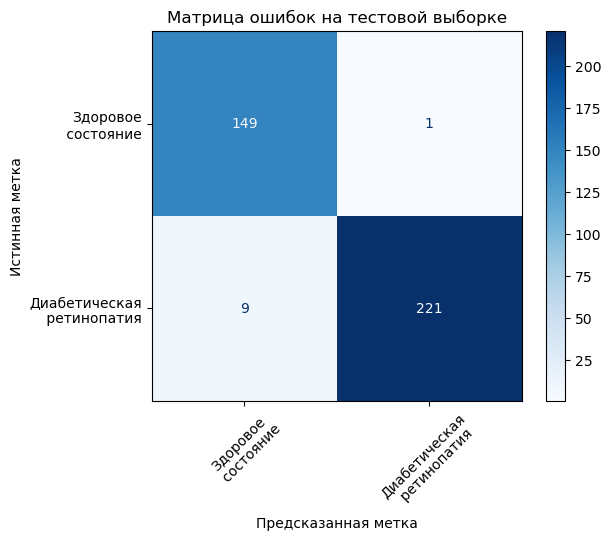

In [20]:
from utils.model import BinaryImprovedCNN

model = BinaryImprovedCNN()
model.load_state_dict(torch.load("data/model2.pth"))
model.eval()

evaluate_binary_model(
    model,
    test_loader,
    class_names=["Здоровое\n состояние", "Диабетическая\n ретинопатия"],
    threshold=0.5 
)

Предсказание: Diabetic Retinopathy
Healthy:              0.0000 (0.00%)
Diabetic Retinopathy: 1.0000 (100.00%)
Истинная метка: Diabetic Retinopathy


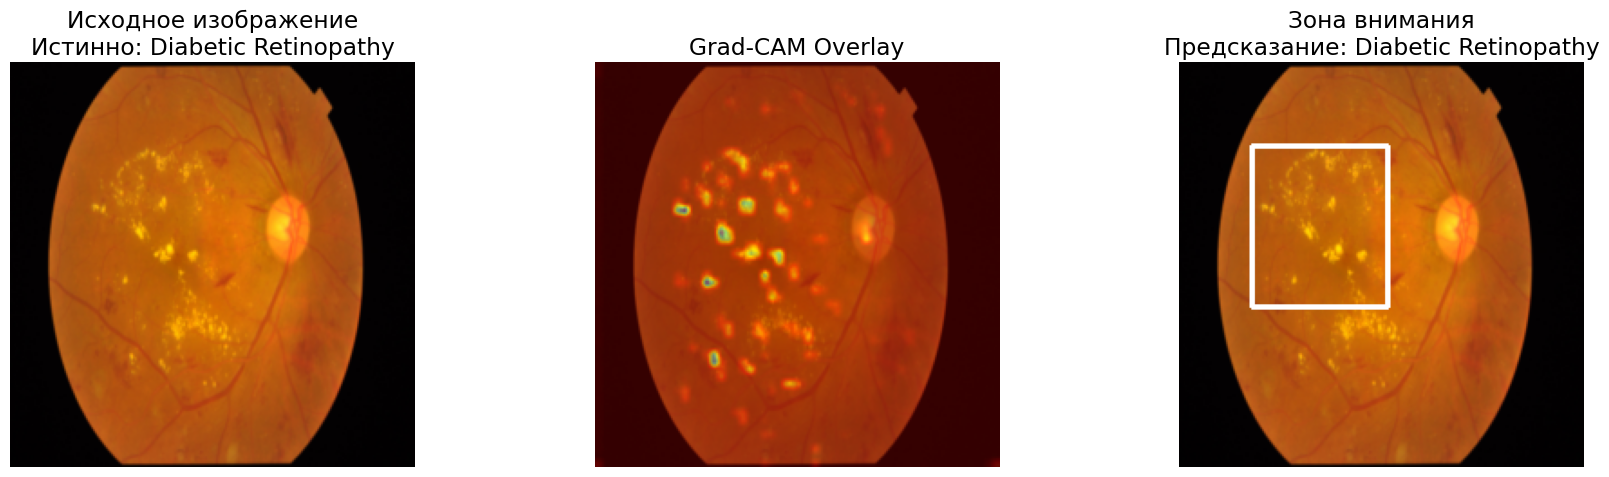

In [ ]:
import random
from utils.visualisation import generate_gradcam, draw_merged_boxes
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2

# Определяем устройство для вычислений
device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available() else "cpu")

# Последовательность преобразований для тестового изображения
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменяем размер до 224x224
    transforms.ToTensor()           # Преобразуем в тензор PyTorch
])

# Выбираем случайный пример из тестовой выборки
idx = random.randint(0, len(test_loader.dataset) - 1)
original_image, label = test_loader.dataset[idx]

# Конвертируем изображение и переводим в numpy-массив для визуализации
original_pil = transforms.ToPILImage()(original_image).convert("RGB")
original_np = np.array(original_pil)

# Применяем те же преобразования, что и при обучении, и переносим на устройство
input_tensor = transform(original_pil).to(device)
input_tensor_unsq = input_tensor.unsqueeze(0)  # Добавляем размерность батча

# Получаем предсказание модели и вероятность класса
model.eval()
model.to(device)
with torch.no_grad():
    output = model(input_tensor_unsq)
    prob = torch.sigmoid(output).item()
    prediction = int(prob >= 0.5)

# Генерируем тепловую карту внимания (Grad-CAM) для предсказанного класса
overlay_small, cam_resized_small = generate_gradcam(
    model, input_tensor, target_class=prediction)

# Масштабируем тепловую карту до исходного размера изображения
overlay = cv2.resize(
    overlay_small, (original_np.shape[1], original_np.shape[0]))
cam_resized = cv2.resize(
    cam_resized_small, (original_np.shape[1], original_np.shape[0]))

# Выделяем зоны внимания на изображении по тепловой карте
boxed_overlay = draw_merged_boxes(
    original_np, cam_resized,
    threshold=0.2,  # Порог для выделения областей
    dilation_iter=3, # Количество итераций дилатации
    min_area=200,  # Минимальная площадь области
    merge_distance=20  # Максимальное расстояние для объединения прямоугольников
)

# Формируем подписи классов и вероятности
class_names = ["Healthy", "Diabetic Retinopathy"]
true_class = class_names[label]  # Истинный класс
pred_class = class_names[prediction]  # Предсказанный класс
prob_healthy = 1 - prob  # Вероятность "Healthy"
prob_dr = prob  # Вероятность "Diabetic Retinopathy"

# Выводим информацию о предсказании
print(f"Предсказание: {pred_class}")
print(f"Healthy:              {prob_healthy:.4f} ({prob_healthy*100:.2f}%)")
print(f"Diabetic Retinopathy: {prob_dr:.4f} ({prob_dr*100:.2f}%)")
print(f"Истинная метка: {true_class}")

# Визуализируем исходное изображение, Grad-CAM и зоны внимания
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.title(f"Исходное изображение\nИстинно: {true_class}")
plt.imshow(original_np)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Зона внимания\nПредсказание: {pred_class}")
plt.imshow(boxed_overlay)
plt.axis("off")

plt.tight_layout()
plt.show()

## Топология модели

In [1]:
import os
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"

import torch
from torchviz import make_dot
from utils.model import BinaryCNN

model = BinaryCNN()
dummy_input = torch.randn(1, 3, 224, 224)
output = model(dummy_input)

dot = make_dot(output, params=dict(model.named_parameters()), show_attrs=False, show_saved=False)
dot.format = 'svg' 
dot.render("model_diagram")

'model_diagram.svg'

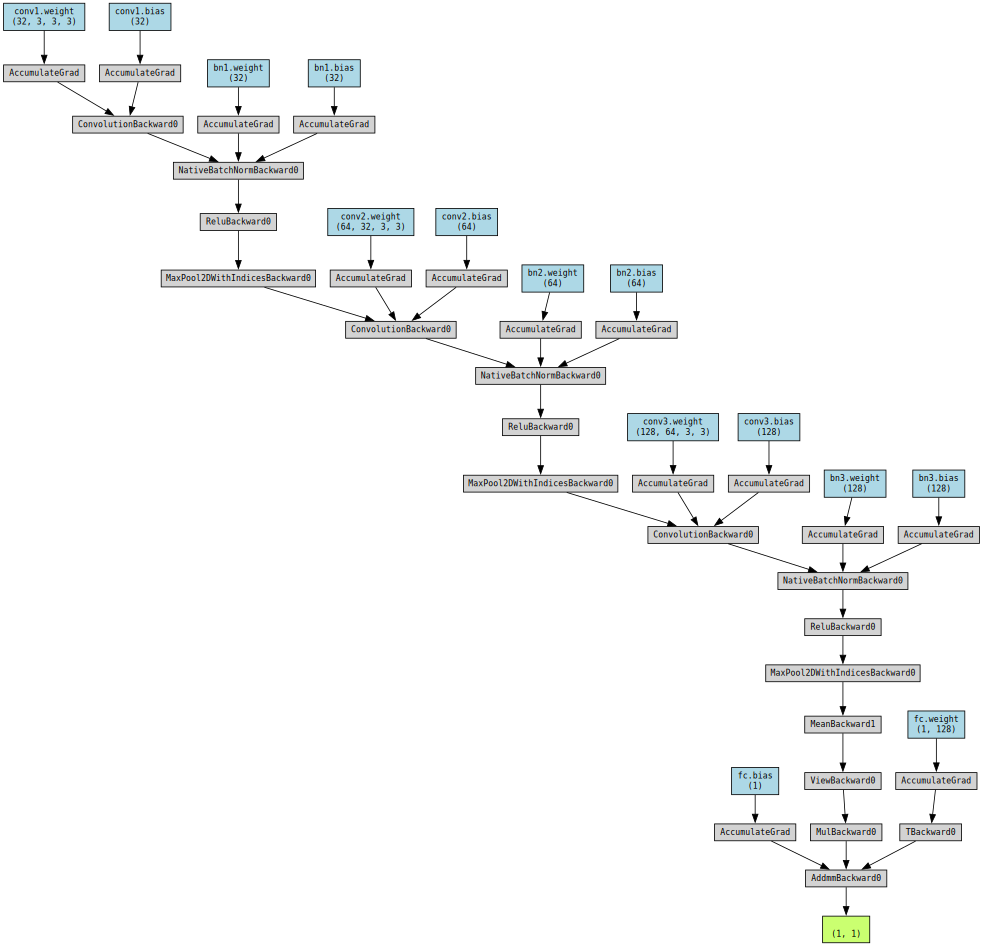

In [2]:
from IPython.display import SVG
dot = make_dot(output, params=dict(model.named_parameters()), show_attrs=False, show_saved=False)

SVG(dot.pipe(format='svg'))

In [16]:
from torchview import draw_graph
from utils.model import BinaryCNN

model = BinaryCNN()
viz = draw_graph(model, input_size=(1, 3, 224, 224), graph_name='BinaryCNN', save_graph=False)
viz.visual_graph.render("model_architecture", format="svg")

'model_architecture.svg'

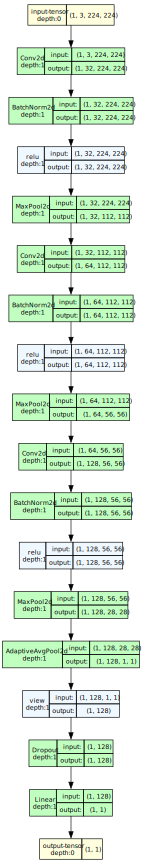

In [4]:
from IPython.display import SVG

SVG(viz.visual_graph.pipe(format='svg'))